In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os

In [223]:
df = pd.read_csv("../data/nigeria_traffic_data.csv")
df.shape, df.columns

((896, 9),
 Index(['Source', 'Destination', 'Road Length (km)', 'Congestion Level',
        'Average Speed (km/h)', 'Travel Time (min)', 'Weather',
        'Alternative Routes', 'Suitability Score'],
       dtype='object'))

In [224]:
lagos_df = df[(df["Source"] == "Lagos") | (df["Destination"] == "Lagos")].copy()
lagos_df.reset_index(drop=True, inplace=True)

In [225]:
congestion_map = {'Low': 1, 'Medium': 2, 'High': 3}
lagos_df["Congestion Level"] = lagos_df["Congestion Level"].map(congestion_map)


weather_map = {'Clear': 0, 'Cloudy': 1, 'Rainy': 2, 'Foggy': 3}

lagos_df["Weather"] = lagos_df["Weather"].map(weather_map)

lagos_df["direction"] = lagos_df["Source"].apply(lambda x: 1 if x == "Lagos" else 0)

print(f"Before removing duplicates: {len(lagos_df)} rows")
lagos_df = lagos_df.drop_duplicates()
print(f"After removing duplicates: {len(lagos_df)} rows")

# dropping text features and not used columns (including average speed to avoid data leakage)
lagos_df.drop(['Source', 'Destination', 'Alternative Routes', 'Suitability Score', 'Average Speed (km/h)'], axis=1, inplace=True)

print(f"Remaining features: {list(lagos_df.columns)}")
print(f"Unique travel times: {lagos_df['Travel Time (min)'].nunique()}")

Before removing duplicates: 203 rows
After removing duplicates: 203 rows
Remaining features: ['Road Length (km)', 'Congestion Level', 'Travel Time (min)', 'Weather', 'direction']
Unique travel times: 16


DEBUGGING: Checking for data leakage...
Dataset shape: (203, 5)
Columns: ['Road Length (km)', 'Congestion Level', 'Travel Time (min)', 'Weather', 'direction']

First few rows:
   Road Length (km)  Congestion Level  Travel Time (min)  Weather  direction
0        772.262244                 1             501.65        1          1
1        989.642155                 2             653.26        2          1
2        558.684404                 1             404.41        0          1
3        602.375745                 1             496.52        0          0
4        957.130399                 2             676.55        0          1

Duplicate rows: 78
Unique Travel Time values: 16
Total rows: 203

Correlation with Travel Time:
Travel Time (min)    1.000000
Road Length (km)     0.985880
Weather              0.158138
direction            0.025317
Congestion Level     0.002279
Name: Travel Time (min), dtype: float64


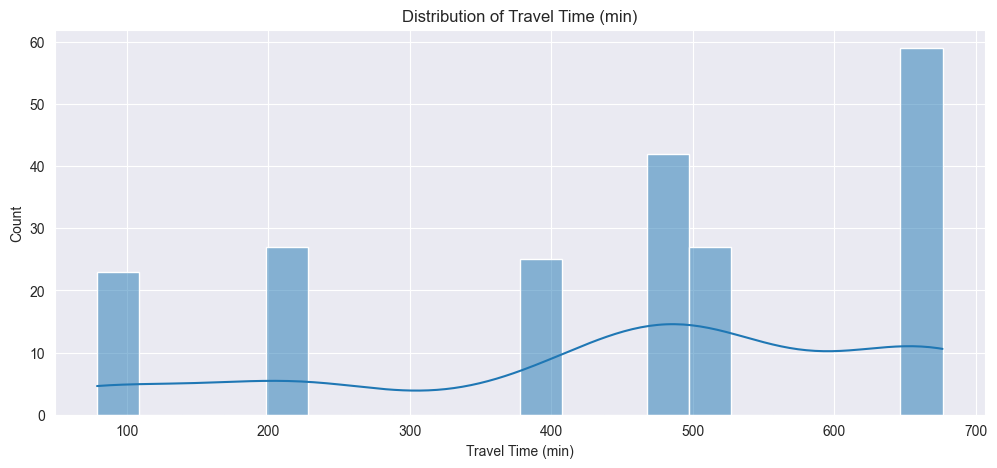

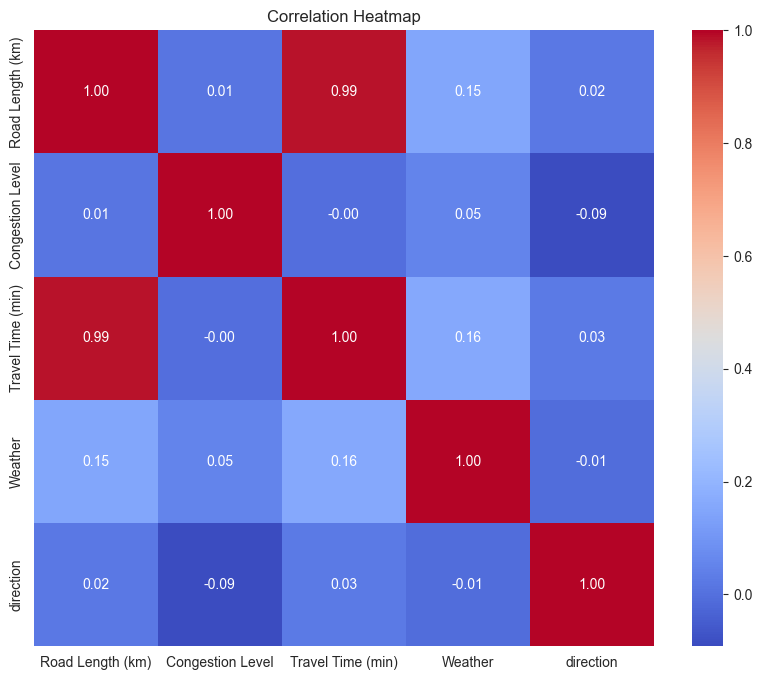

In [226]:
print("DEBUGGING: Checking for data leakage...")
print(f"Dataset shape: {lagos_df.shape}")
print(f"Columns: {list(lagos_df.columns)}")
print("\nFirst few rows:")
print(lagos_df.head())

print(f"\nDuplicate rows: {lagos_df.duplicated().sum()}")
print(f"Unique Travel Time values: {lagos_df['Travel Time (min)'].nunique()}")
print(f"Total rows: {len(lagos_df)}")

print("\nCorrelation with Travel Time:")
correlations = lagos_df.corr()['Travel Time (min)'].abs().sort_values(ascending=False)
print(correlations)

perfect_corr = correlations[correlations >= 0.99]
if len(perfect_corr) > 1: 
    print("Found near-perfect correlations!")
    print(perfect_corr)

plt.figure(figsize=(12, 5))
sns.histplot(lagos_df['Travel Time (min)'], bins=20, kde=True)
plt.title("Distribution of Travel Time (min)")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(lagos_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [227]:
X = lagos_df[[
    'Road Length (km)',
    'Weather',
    'direction',
    'Congestion Level'
]]
y = lagos_df['Travel Time (min)']



In [228]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [229]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [230]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

In [231]:
dt_model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=3, random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

In [232]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=4, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [237]:
def evaluate_model (name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - RMSE: {rmse:.2f}, R2: {r2:.3f}")
    return rmse, r2

lr_rmse, lr_r2 = evaluate_model("Linear Regression", y_test, y_pred_lr)
dt_rmse, dt_r2 = evaluate_model("Decision Tree", y_test, y_pred_dt)
rf_rmse, rf_r2 = evaluate_model("Random Forest", y_test, y_pred_rf)

models = {
    'Linear Regression': (lr_model, lr_rmse, y_pred_lr),
    'Decision Tree': (dt_model, dt_rmse, y_pred_dt),
    'Random Forest': (rf_model, rf_rmse, y_pred_rf)
}

best_model_name = min(models.keys(), key=lambda x: models[x][1])
best_model = models[best_model_name][0]
best_predictions = models[best_model_name][2]

print(f"\nBest Model: {best_model_name} (RMSE: {models[best_model_name][1]:.2f})")

Linear Regression - RMSE: 31.06, R2: 0.979
Decision Tree - RMSE: 1.29, R2: 1.000
Random Forest - RMSE: 0.69, R2: 1.000

Best Model: Random Forest (RMSE: 0.69)


In [238]:
os.makedirs("../models", exist_ok=True)

joblib.dump(best_model, "../models/best_model.pkl")
joblib.dump(scaler, "../models/scaler.pkl")

['../models/scaler.pkl']


Feature Importance (Random Forest):
            feature    importance
0  Road Length (km)  9.999924e-01
2         direction  7.390713e-06
1           Weather  1.065214e-07
3  Congestion Level  7.568627e-08


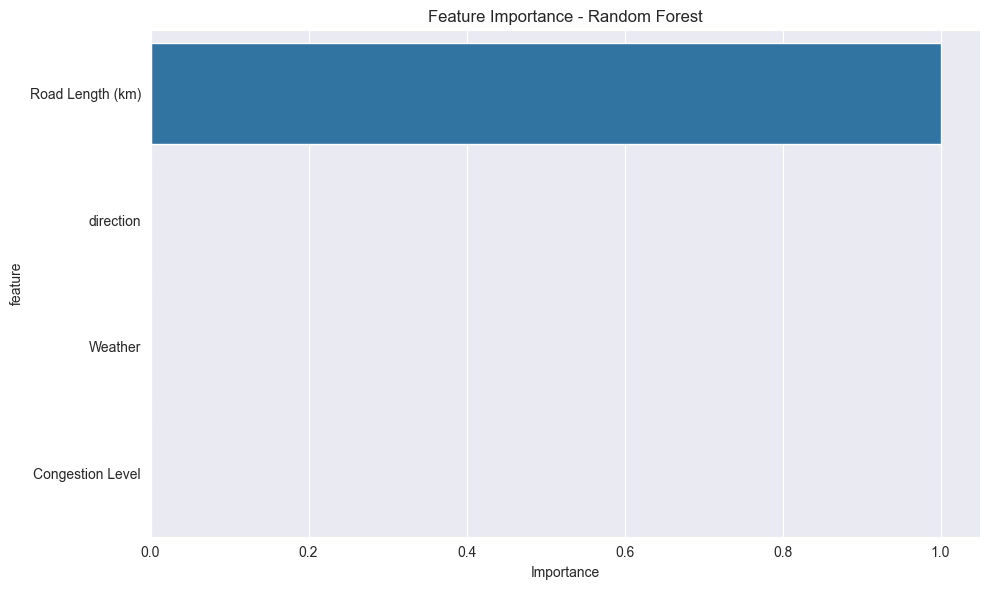

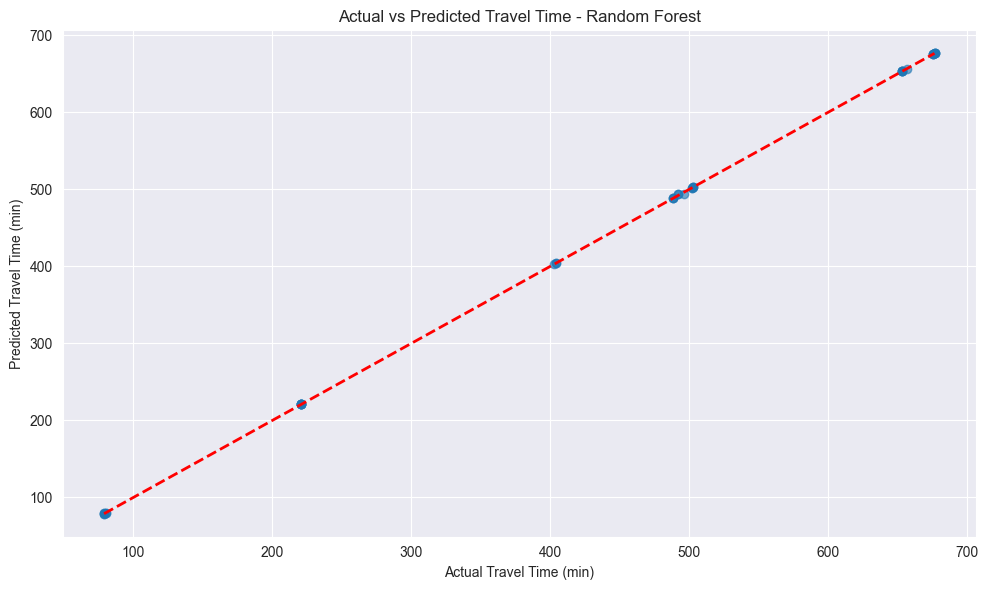

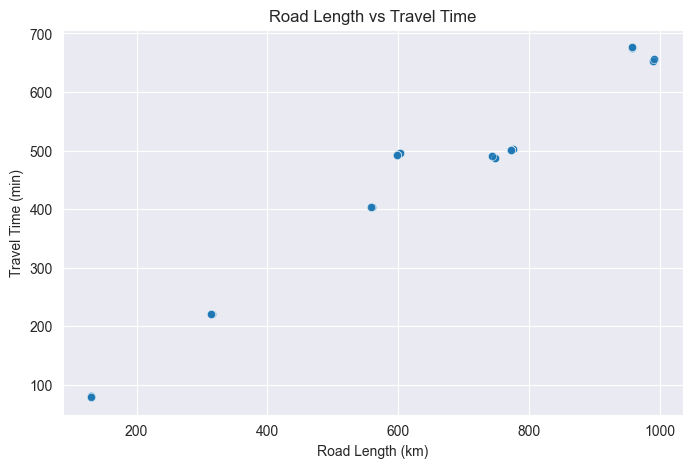

In [239]:
if best_model_name == 'Random Forest':
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance (Random Forest):")
    print(feature_importance)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title('Feature Importance - Random Forest')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

elif best_model_name == 'Linear Regression':
    feature_coef = pd.DataFrame({
        'feature': X.columns,
        'coefficient': best_model.coef_
    }).sort_values('coefficient', key=abs, ascending=False)
    
    print("\nFeature Coefficients (Linear Regression):")
    print(feature_coef)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_coef, x='coefficient', y='feature')
    plt.title('Feature Coefficients - Linear Regression')
    plt.xlabel('Coefficient')
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Travel Time (min)')
plt.ylabel('Predicted Travel Time (min)')
plt.title(f'Actual vs Predicted Travel Time - {best_model_name}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x=lagos_df['Road Length (km)'], y=lagos_df['Travel Time (min)'], alpha=0.6)
plt.title("Road Length vs Travel Time")
plt.xlabel("Road Length (km)")
plt.ylabel("Travel Time (min)")
plt.show()

In [240]:
print(lagos_df['Travel Time (min)'].min())
print(lagos_df['Travel Time (min)'].describe())

print(y_pred_lr.min(), y_pred_lr.max())
print(y_pred_dt.min(), y_pred_dt.max())
print(y_pred_rf.min(), y_pred_rf.max())


78.82
count    203.000000
mean     449.958473
std      192.920731
min       78.820000
25%      403.020000
50%      492.150000
75%      653.260000
max      676.550000
Name: Travel Time (min), dtype: float64
106.191616756695 682.8132494934209
78.82000000000001 676.5500000000001
79.0832152777777 676.5227491734581
